In [1]:
library(reticulate)
library(anndata)
library(Seurat)
library(dplyr)
library(simspec)
library(Matrix)
sc <- import('scanpy')


Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:


adata <- sc$read_h5ad(paste0(PATH_FILE, 'exp1_processed.h5ad'))

In [3]:
adata_raw <- sc$read_h5ad(paste0(PATH_FILE, 'exp1_raw.h5ad'))

In [4]:

counts <- t(adata_raw$X)
dimnames(counts) <- list(adata_raw$var_names, adata_raw$obs_names)

In [5]:
seurat <- CreateSeuratObject(counts , meta.data = adata$obs, project='exp_revision')

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is n_genes_by_countstotal_countstotal_counts_mtpct_counts_mtsampleliboriginal_namecondition._xcondition._ycondition_name_fullcell_line_1cell_line_2batchmediummorphogenmorphogen_fullBatch_Mediummedium_morphogenleiden; see ?make.names for more details on syntax validity”


In [9]:
dim(adata$raw$X)
expr <- t(adata$raw$X)

[1] 214059  43558

In [11]:

if (inherits(expr, "dgRMatrix")) {
  expr <- as(as.matrix(expr), "dgCMatrix")
}

# Assign proper row and column names (assuming rownames and colnames come from Seurat object)
dimnames(expr) <- list(rownames(seurat), colnames(seurat))

seurat[['RNA']]@data <- expr

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 69.5 GiB”


In [48]:
pca <- adata$obsm[['X_pca']]
rownames(pca) <- colnames(seurat)
seurat[['pca']] <- CreateDimReducObject(pca, key='PCA_')




Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“No columnames present in cell embeddings, setting to 'PCA_1:150'”


In [17]:
umap <- adata$obsm[['X_umap']]
rownames(umap) <- colnames(seurat)
seurat[['umap']] <- CreateDimReducObject(umap, key='UMAP_')
seurat

Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“No columnames present in cell embeddings, setting to 'UMAP_1:2'”


An object of class Seurat 
43558 features across 214059 samples within 1 assay 
Active assay: RNA (43558 features, 0 variable features)
 1 dimensional reduction calculated: umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



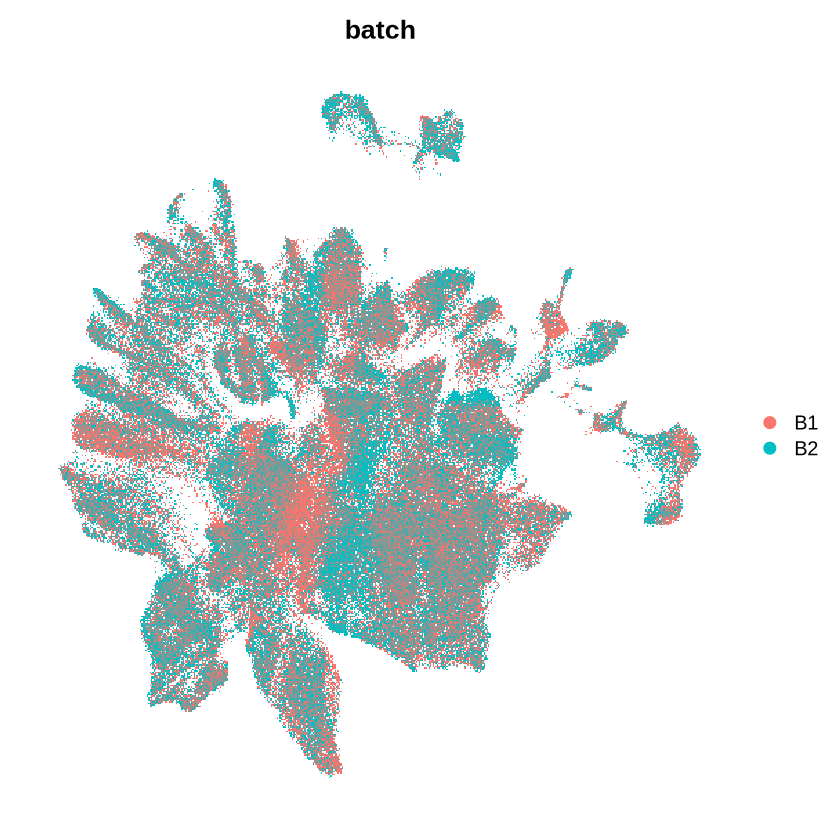

In [28]:
UMAPPlot(seurat, group.by='batch') & NoAxes()

# Check RSS

In [2]:
ref <- readRDS(paste0(PATH_FILE, "HumanBrainDevPool_cluster_logexpr_highvar.rds"))
# read prepared primary data file

In [3]:
seurat <- ref_sim_spectrum (seurat, ref)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”
Warning message:
“No columnames present in cell embeddings, setting to 'RSS_1:703'”


In [4]:
seurat <- CellCycleScoring(seurat,
                                  s.features = cc.genes$s.genes,
                                  g2m.features = cc.genes$g2m.genes,
                                  set.ident = TRUE)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”


In [5]:
# Compute the correlation between the cc scores and the PCA components (makes a matrix: cc.scores vs PC)
corr_seurat <- cor (seurat@meta.data [ , c("S.Score","G2M.Score")], Embeddings (seurat, "rss"))

# Those PCs that are not correlated with the cc scores are retained, the others are eliminated
remained <- abs(corr_seurat) < 0.5

# Now we create an integer object to define which PCs should be used for downstream analysis (taking into account their correlation with CC scores)
# We take the columns (PCs) that have low correlation with S and G2M scores (TRUE in both rows)
idx_used_pcs <- which (colSums(remained) == 2)


# Running UMAP + clustering algorithms on the integrated data

# Need to increase the max size of the objects to be plotted, otherwise clustering throws an error
options(future.globals.maxSize= 891289600) 

# Setting rss dims to use
intersected_dims_noCC <- c (intersect (1:ncol (Embeddings (seurat, "rss")), idx_used_pcs))

seurat <- seurat %>% 
  RunUMAP (reduction = "rss",  dims = intersected_dims_noCC,  reduction.name = "umap_rss") %>% 
 FindNeighbors (reduction = "rss", dims = intersected_dims_noCC) %>% 
  FindClusters (resolution = 1)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
09:09:27 UMAP embedding parameters a = 0.9922 b = 1.112

09:09:28 Read 214059 rows and found 516 numeric columns

09:09:28 Using Annoy for neighbor search, n_neighbors = 30

09:09:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:11:29 Writing NN index file to temp file /tmp/Rtmp3xzI2l/file15f06d72e2ee8a

09:11:29 Searching Annoy index using 1 thread, search_k = 3000

09:18:08 Annoy recall = 100%

09:18:09 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighb

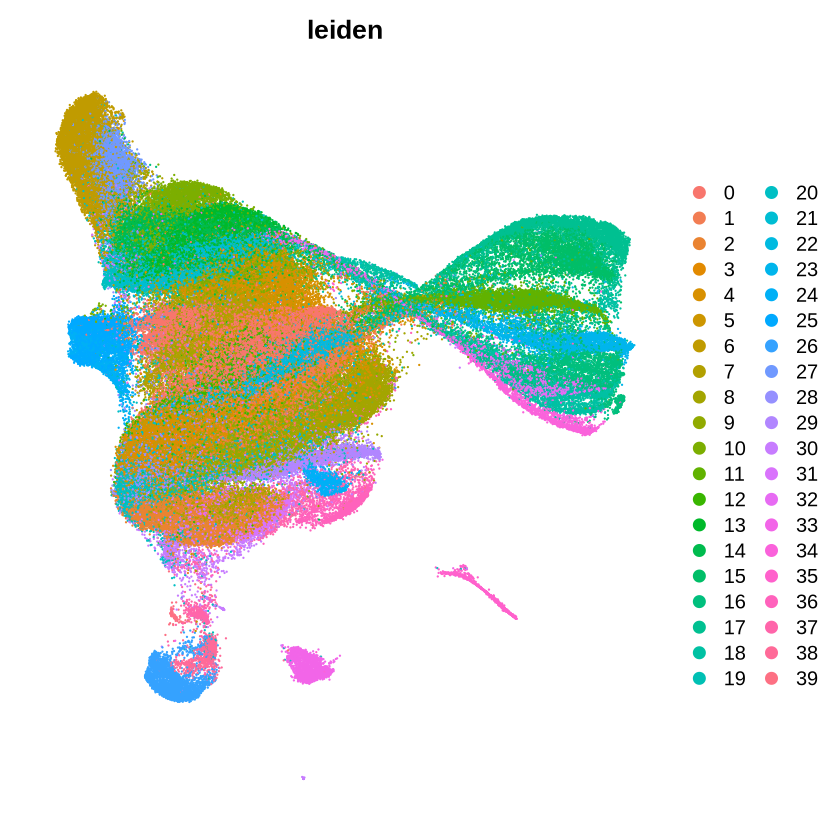

In [6]:

DimPlot(seurat, group.by = "leiden", reduction = "umap_rss", raster=F) & NoAxes()

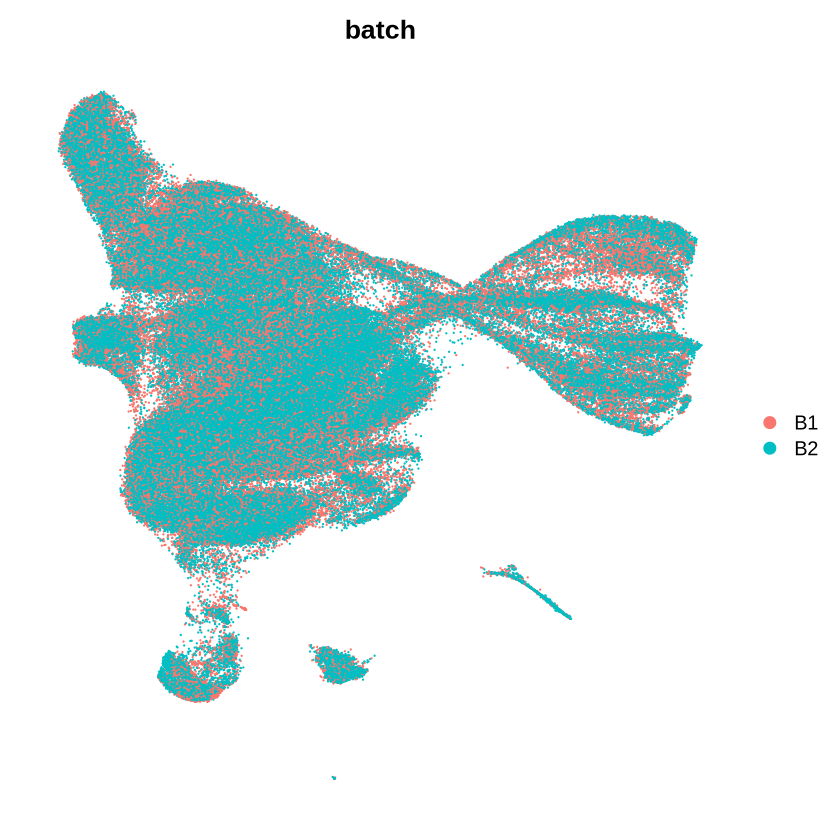

In [7]:
DimPlot(seurat, group.by = "batch", reduction = "umap_rss", raster=F) & NoAxes()

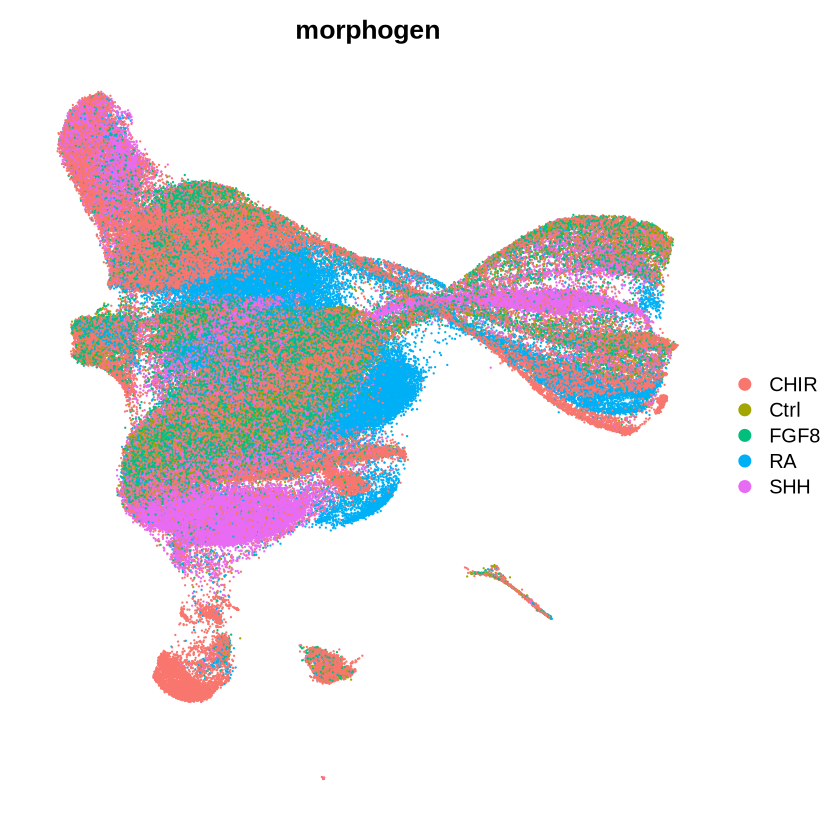

In [8]:
DimPlot(seurat, group.by = "morphogen", reduction = "umap_rss", raster=F) & NoAxes()

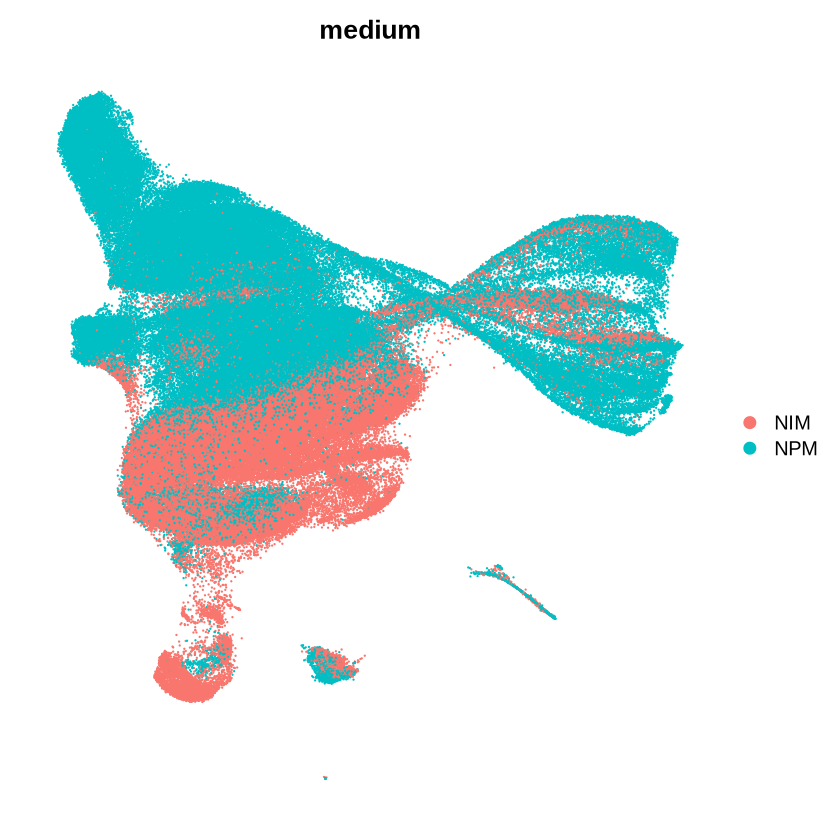

In [9]:
DimPlot(seurat, group.by = "medium", reduction = "umap_rss", raster=F) & NoAxes()

In [12]:
saveRDS(seurat, paste0(PATH_FILE, 'exp1_processed_rss_2.rds'))

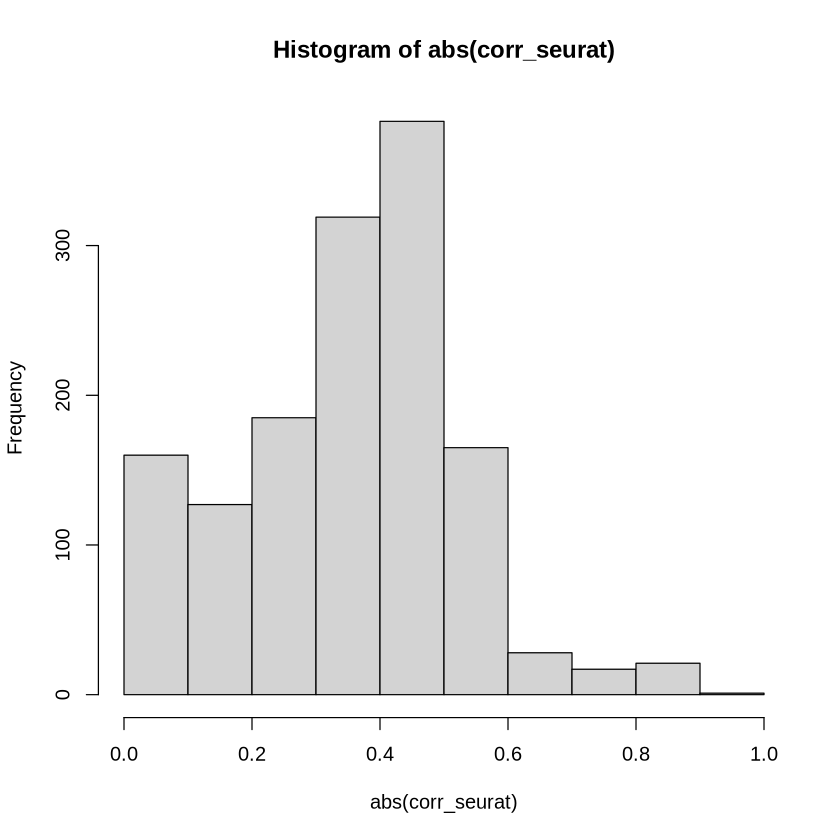

In [63]:
hist(abs(corr_seurat))

In [51]:
# SAVE EMBEDDINGS
umap_embeddings <- seurat@reductions[["umap_rss"]]@cell.embeddings

# Set the row names to your original names
rownames(umap_embeddings) <- seurat$original_name

# Assign the modified embeddings back to the Seurat object
seurat@reductions[["umap_rss"]]@cell.embeddings <- umap_embeddings



write.table(Embeddings(seurat, "umap_rss"),  paste0(PATH_FILE, 'umap_rss.tsv', sep='\t'))

In [52]:
rss_embeddings <- seurat@reductions[["rss"]]@cell.embeddings

# Set the row names to your original names
rownames(rss_embeddings) <- seurat$original_name

# Assign the modified embeddings back to the Seurat object
seurat@reductions[["rss"]]@cell.embeddings <- rss_embeddings


write.table(Embeddings(seurat, "rss"),   paste0(PATH_FILE, 'rss.tsv', sep='\t'))

In [ ]:
options(future.globals.maxSize= 891289600) 
seurat <- seurat %>% 
  #RunUMAP (reduction = "rss",  dims = intersected_dims_noCC,  reduction.name = "umap_rss") #%>% 
 FindNeighbors (reduction = "rss", dims = intersected_dims_noCC) %>% 
  FindClusters (resolution = 1)



Computing nearest neighbor graph



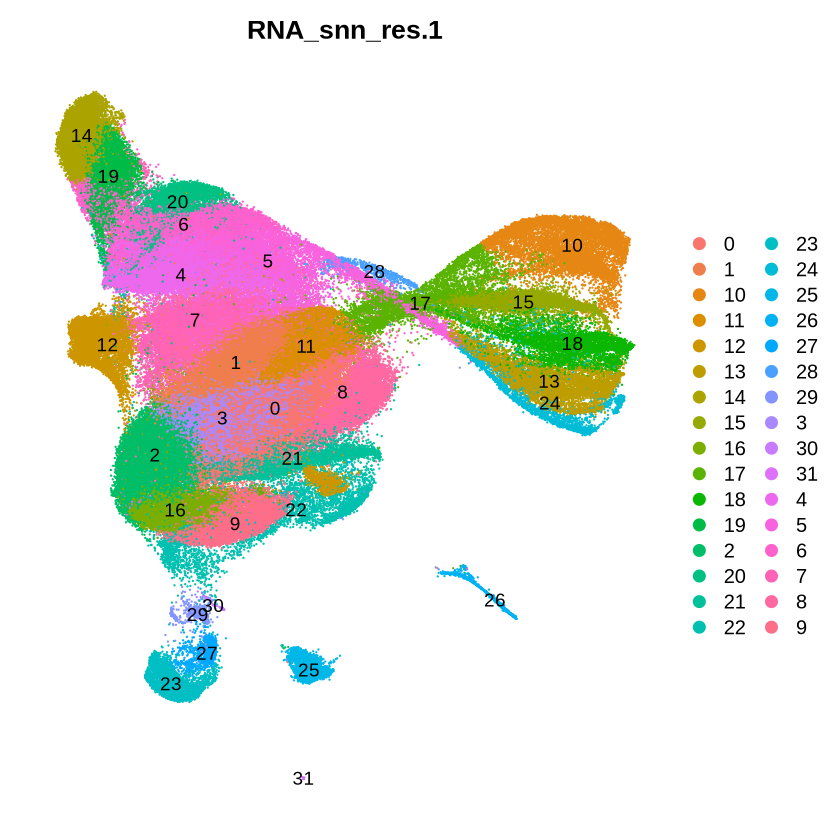

In [5]:
DimPlot(seurat, group.by = "RNA_snn_res.1", reduction = "umap_rss", raster=F,label = TRUE) & NoAxes()

In [ ]:
saveRDS(seurat,  paste0(PATH_FILE, 'exp1_processed_rss_4.rds'))

# Neurons only subcluster

In [4]:
Idents(seurat) <- 'fullname_v3'

neurons<-subset(x = seurat, idents = c("CNS Neurons", "PNS Neurons"))

neurons


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_rss_ to umaprss_”


An object of class Seurat 
43558 features across 37019 samples within 1 assay 
Active assay: RNA (43558 features, 0 variable features)
 3 dimensional reductions calculated: umap, rss, umap_rss

In [5]:
neurons <- neurons %>% 
  RunUMAP (reduction = "rss",  dims = intersected_dims_noCC,  reduction.name = "umap_rss_neurons") %>% 
    FindNeighbors (reduction = "rss", dims = intersected_dims_noCC) %>% 
            FindClusters (resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:51:42 UMAP embedding parameters a = 0.9922 b = 1.112

21:51:42 Read 37019 rows and found 516 numeric columns

21:51:42 Using Annoy for neighbor search, n_neighbors = 30

21:51:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:51:55 Writing NN index file to temp file /tmp/RtmpQsOoEf/filec1dc4e10d7aa

21:51:56 Searching Annoy index using 1 thread, search_k = 3000

21:52:39 Annoy recall = 100%

21:52:39 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 37019
Number of edges: 1729937

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9094
Number of communities: 17
Elapsed time: 9 seconds


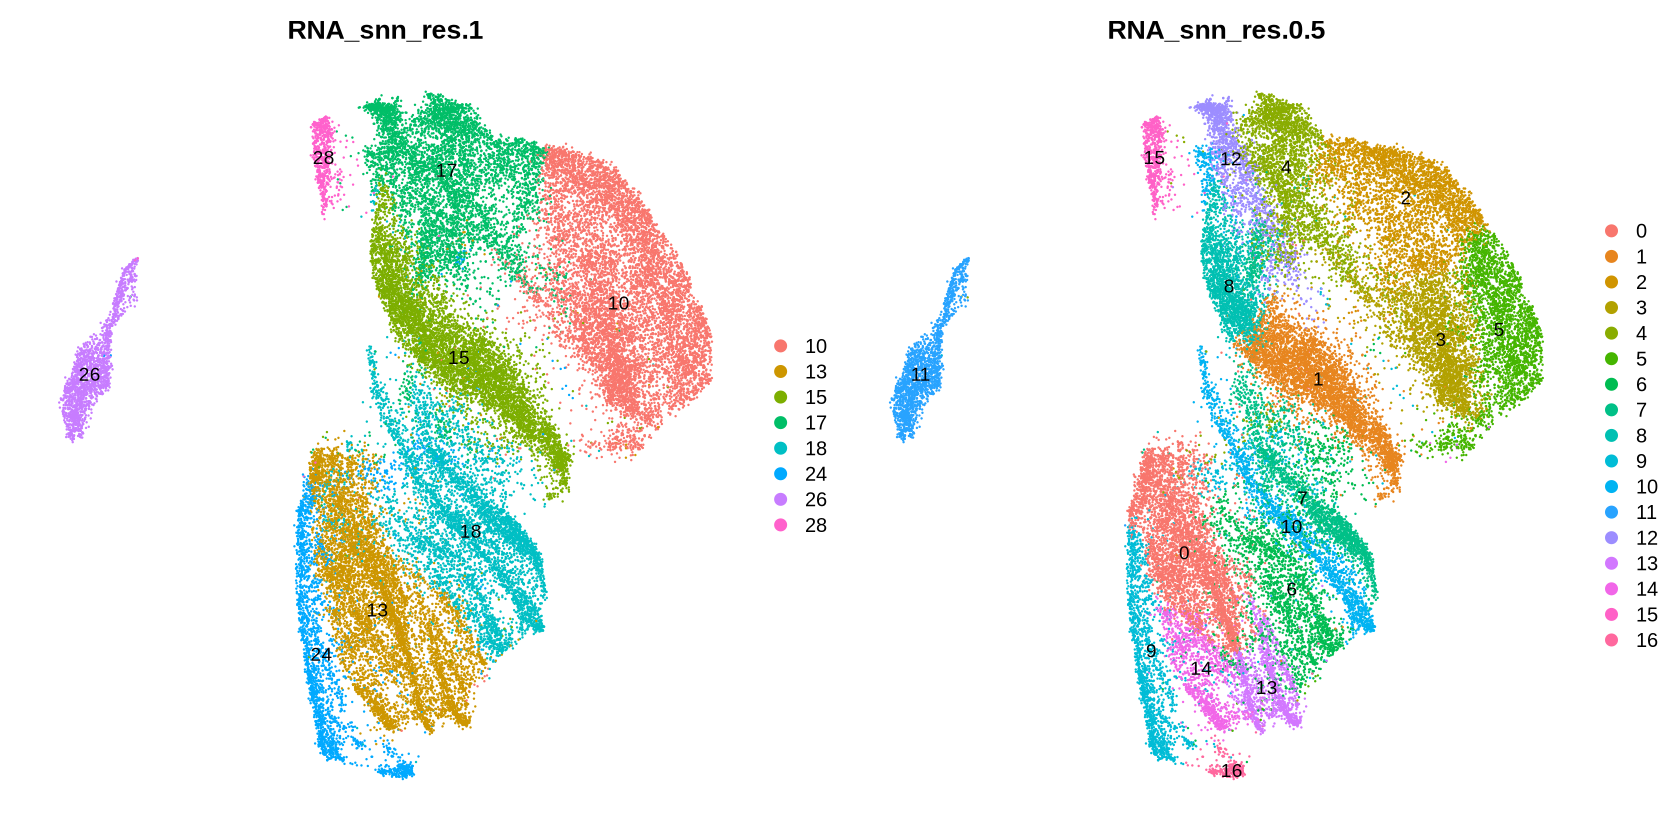

In [7]:
options(repr.plot.height=7, repr.plot.width=14)
DimPlot(neurons, group.by = c("RNA_snn_res.1", "RNA_snn_res.0.5"), 
        reduction = "umap_rss_neurons", raster=F,label = TRUE, ncol=2) & NoAxes()

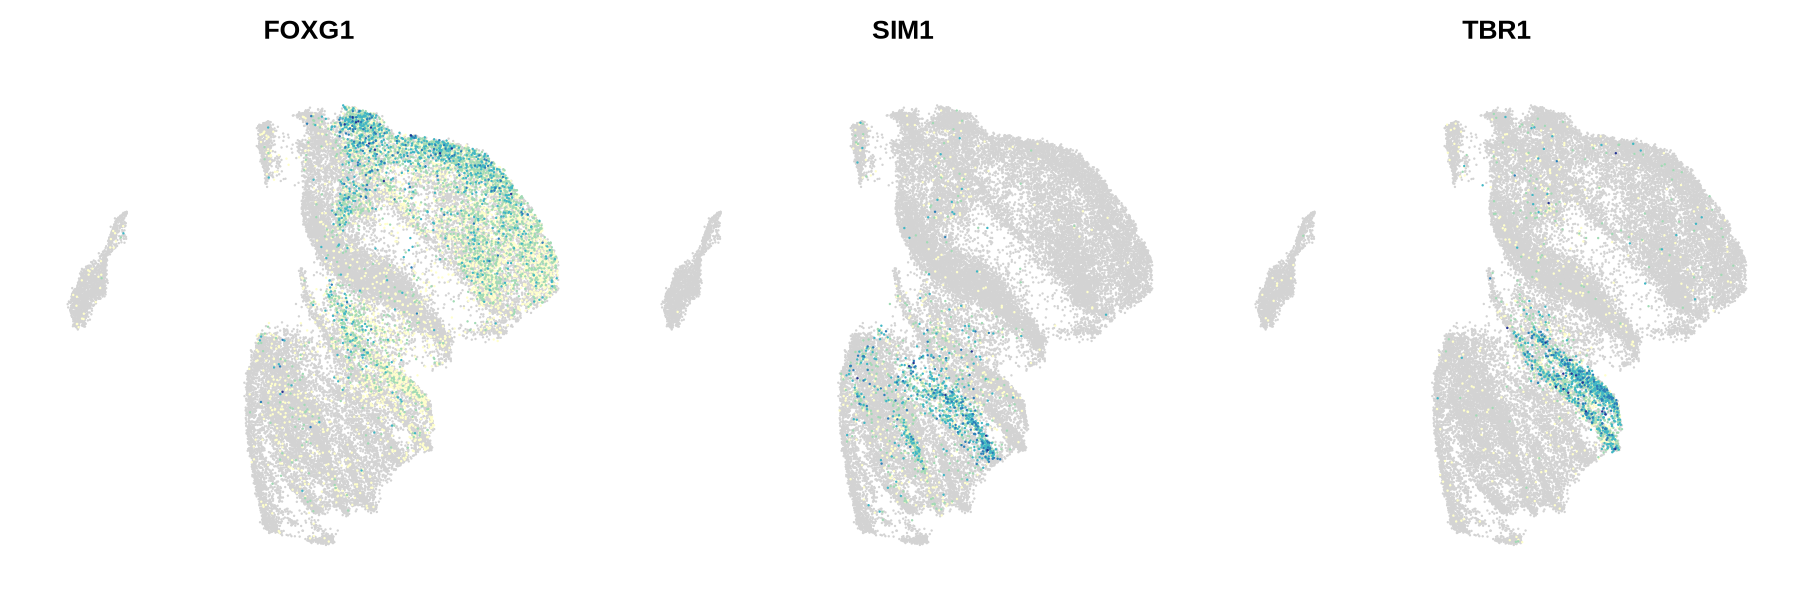

In [10]:
library(pals)
options(repr.plot.height=5, repr.plot.width=15)
FeaturePlot(neurons,
                  features = c('FOXG1', 'SIM1', 'TBR1'),
                  reduction="umap_rss_neurons",
                  order = T,cols=c("lightgrey",brewer.ylgnbu(5)),
                  ncol=3, raster=F) & NoAxes()  &NoLegend()





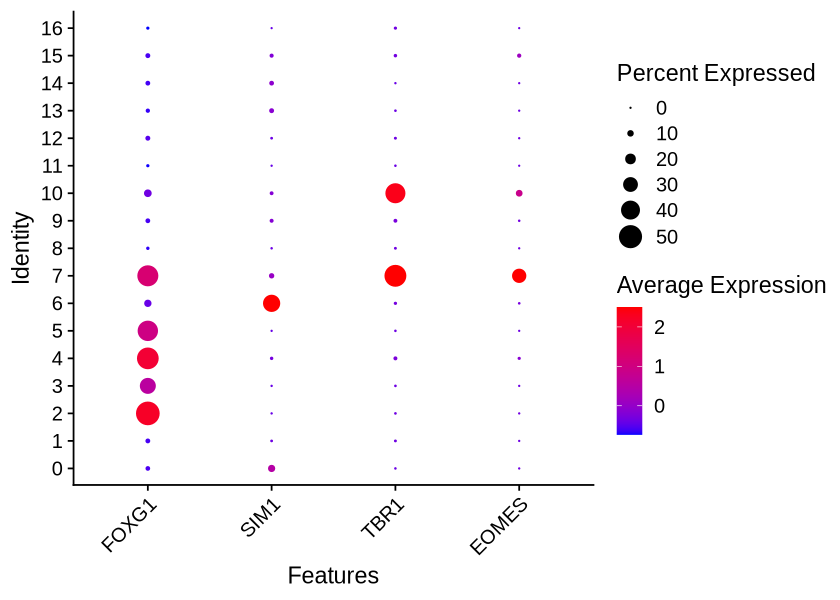

In [24]:
options(repr.plot.height=5, repr.plot.width=7)
Idents(neurons)<-"RNA_snn_res.0.5"
DotPlot(neurons,  features =c('FOXG1', 'SIM1', 'TBR1',"EOMES"), 
        cols= c("blue", "red")
        )+ RotatedAxis()

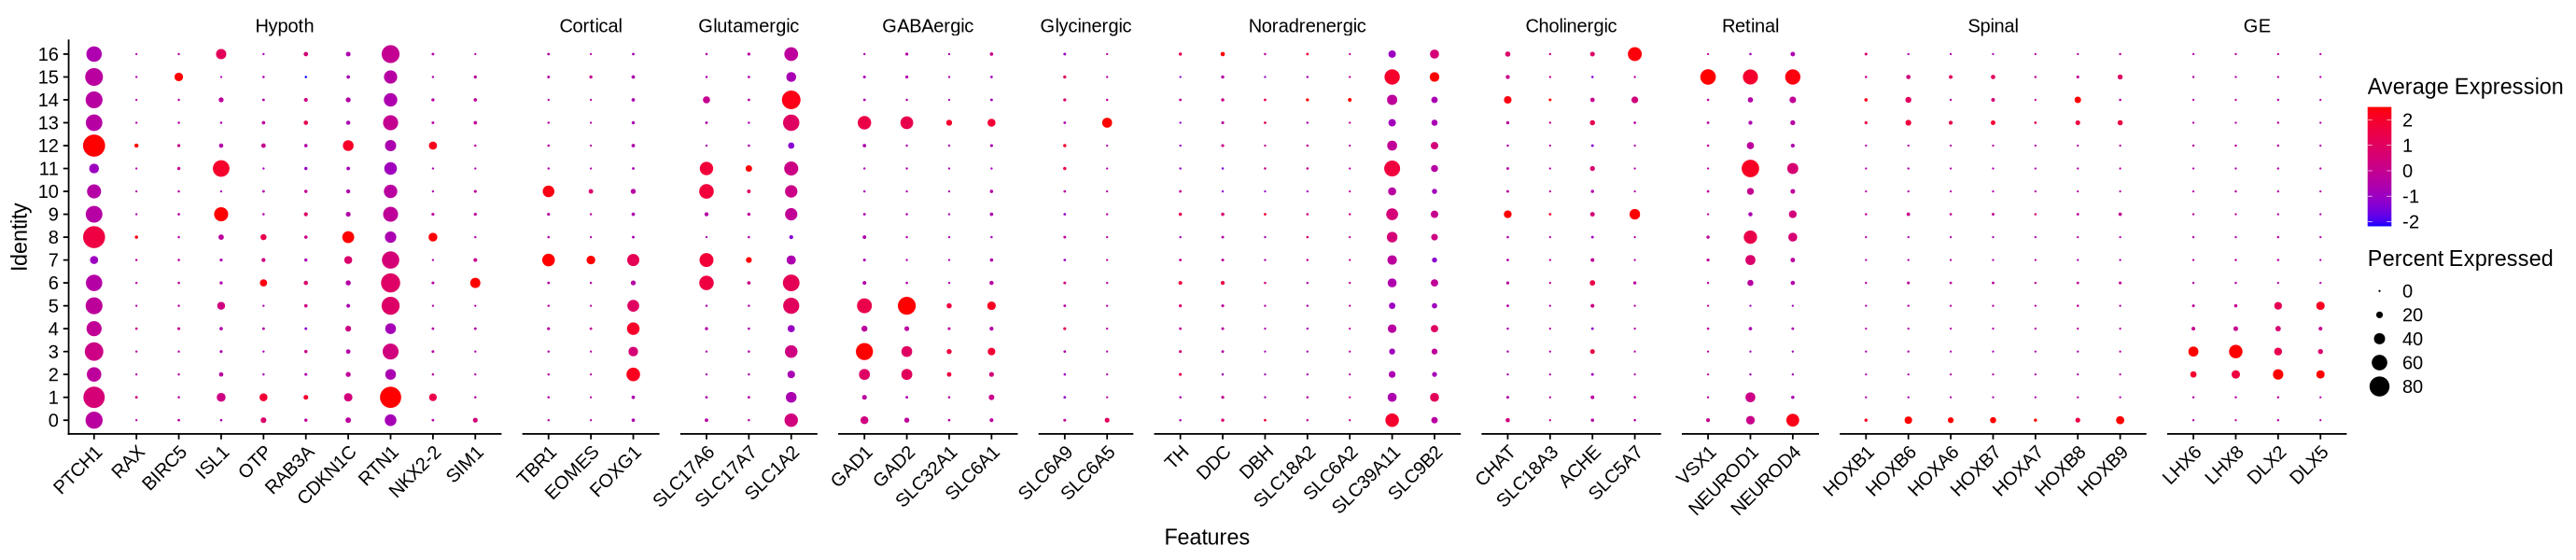

In [50]:
options(repr.plot.height=5, repr.plot.width=23)
marker_genes_neurons_dict <- list(
     Hypoth = c("PTCH1","RAX",'BIRC5', 'ISL1', 'OTP','RAB3A',
                            'CDKN1C',  'RTN1',
                               'NKX2-2', 'SIM1'),
    Cortical = c('TBR1',"EOMES", 'FOXG1'),

    Glutamergic = c('SLC17A6', 'SLC17A7', 'SLC1A2'),
    GABAergic = c('GAD1', 'GAD2', 'SLC32A1', 'SLC6A1'),
    Glycinergic = c('SLC6A9', 'SLC6A5'),
    Noradrenergic = c('TH', 'DDC', 'DBH', 'SLC18A2', 'SLC6A2', 'SLC39A11', 'SLC9B2'),
    Cholinergic = c('CHAT', 'SLC18A3', 'ACHE', 'SLC5A7'),
    Retinal = c("VSX1", "NEUROD1","NEUROD4"),
    Spinal =c('HOXB1', 'HOXB6', 'HOXA6', 'HOXB7', 'HOXA7', 'HOXB8', 'HOXB9'),
    GE=c("LHX6", "LHX8", "DLX2", "DLX5"))
   

#table(marker_genes_neurons_dict)
Idents(neurons)<-"RNA_snn_res.0.5"
DotPlot(neurons,  features =marker_genes_neurons_dict, 
        cols= c("blue", "red")
        )+ RotatedAxis()

In [41]:
neuron_colors <- list(
  'MGE-derived GABA Neurons' = '#e69138',
  'PNS GLY Neurons' = '#d0c7ff',
  'Hypothalamic Neurons SIM1-' = '#ff8cbf',
     'Hypothalamic Neurons SIM1+' = '#f30d73',
  'Cortical Neurons' = '#ff6d01',
  'PNS CHOL Neurons' = '#a66d9b',
  'PNS Neurons' = '#2983aa',
  'Retinal Neurons' = '#ac383f', 
    'MGE-derived GABA Immature Neurons' = '#f6b26b'
)



# Get unique categories from Seurat object's metadata (RNA_snn_res.1 column)
origin <- sort(unique(neurons$RNA_snn_res.0.5))

# Define the corresponding cell types
cell_types <- c(

    'PNS GLY Neurons',
    'Hypothalamic Neurons SIM1-',
    'MGE-derived GABA Neurons',
    'MGE-derived GABA Neurons',
    'MGE-derived GABA Immature Neurons',
     'MGE-derived GABA Neurons',
    'Hypothalamic Neurons SIM1+',
    'Cortical Neurons',
    'Hypothalamic Neurons SIM1-',
    'PNS CHOL Neurons',
     'Cortical Neurons',
    'PNS Neurons',
    'MGE-derived GABA Immature Neurons',
    'PNS GLY Neurons',
    'PNS CHOL Neurons',
    'Retinal Neurons',
     'PNS CHOL Neurons'
)

# Create a data frame mapping RNA_snn_res.1 to neurons_name
dflab <- data.frame(
  RNA_snn_res.0.5 = origin,
  neurons_name = cell_types
)

dflab

RNA_snn_res.0.5 neurons_name                     
1  0               PNS GLY Neurons                  
2  1               Hypothalamic Neurons SIM1-       
3  2               MGE-derived GABA Neurons         
4  3               MGE-derived GABA Neurons         
5  4               MGE-derived GABA Immature Neurons
6  5               MGE-derived GABA Neurons         
7  6               Hypothalamic Neurons SIM1+       
8  7               Cortical Neurons                 
9  8               Hypothalamic Neurons SIM1-       
10 9               PNS CHOL Neurons                 
11 10              Cortical Neurons                 
12 11              PNS Neurons                      
13 12              MGE-derived GABA Immature Neurons
14 13              PNS GLY Neurons                  
15 14              PNS CHOL Neurons                 
16 15              Retinal Neurons                  
17 16              PNS CHOL Neurons

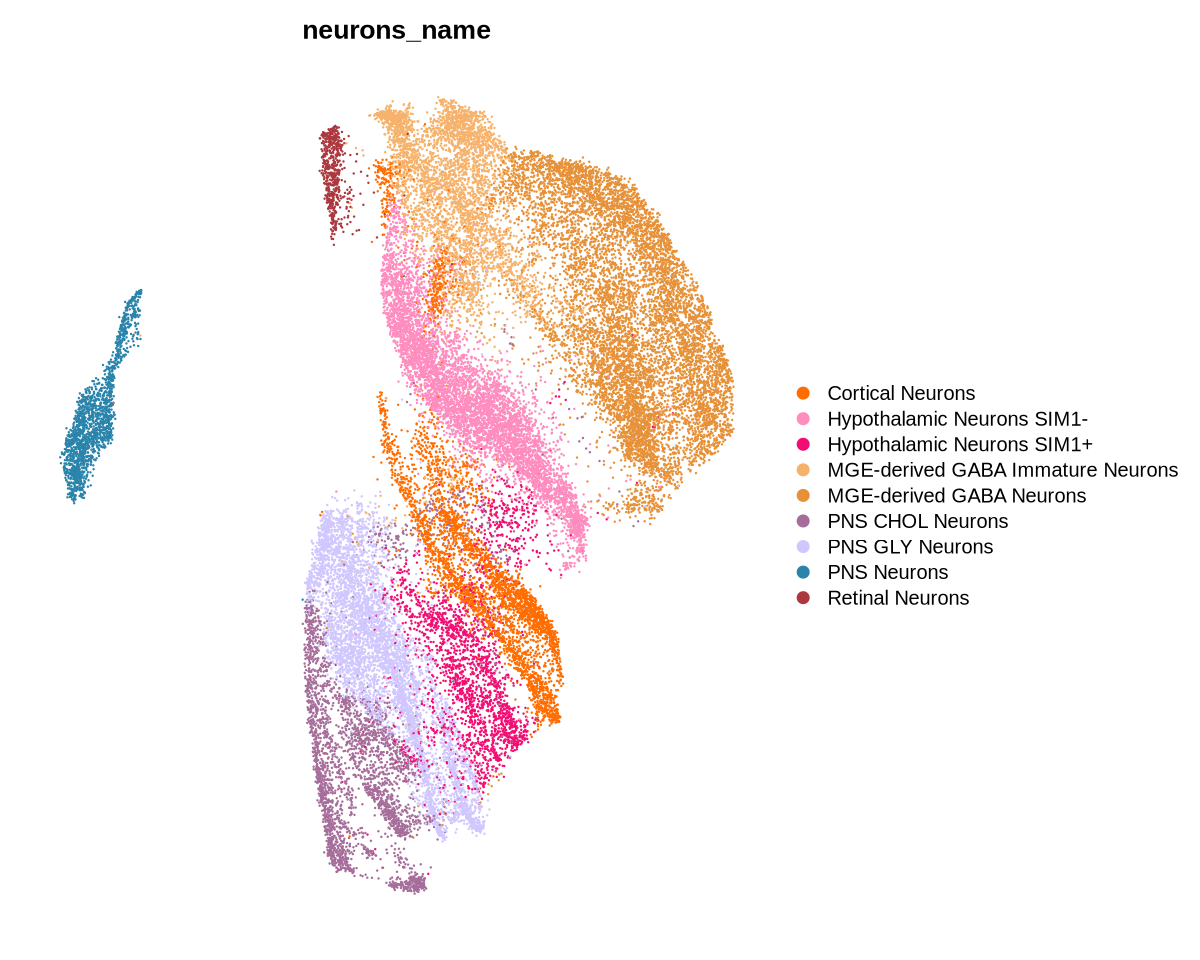

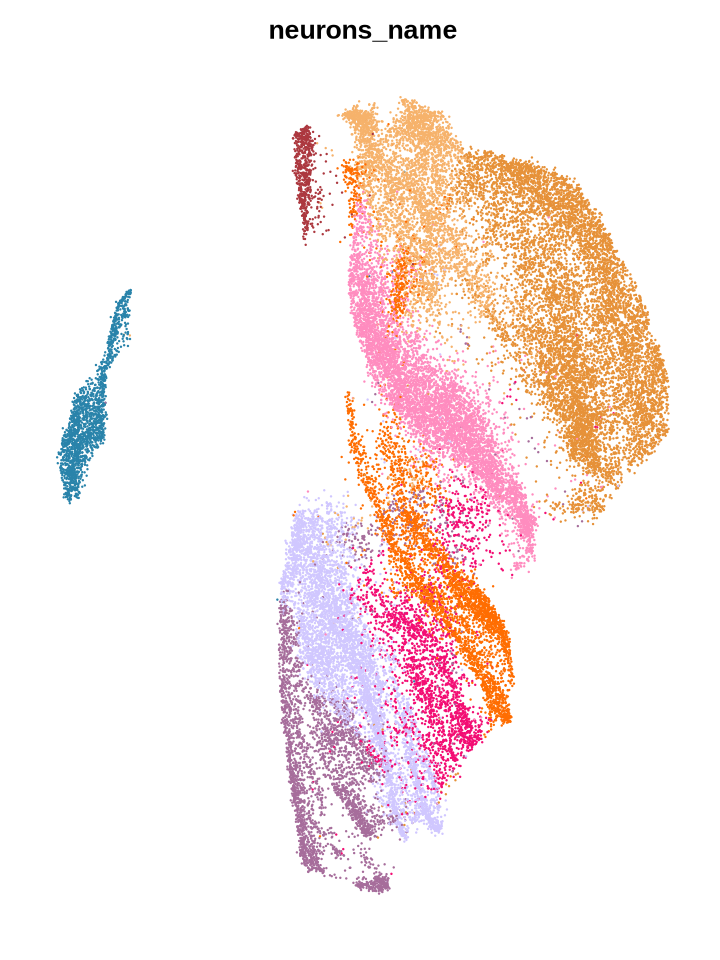

In [46]:
library(ggplot2)
options(repr.plot.height=8, repr.plot.width=10)
neurons <- AddMetaData(neurons, dflab$neurons_name[match(neurons$RNA_snn_res.0.5, dflab$RNA_snn_res.0.5)], col.name = "neurons_name")
DimPlot(neurons, group.by = "neurons_name", reduction = "umap_rss_neurons", raster=F, cols=neuron_colors) & NoAxes()
ggsave( paste0(PATH_FILE, "figures/neurons_leg.pdf"), width = 5, height = 5,dpi=300)

options(repr.plot.height=8, repr.plot.width=6)
DimPlot(neurons, group.by = "neurons_name", reduction = "umap_rss_neurons", raster=F, cols=neuron_colors) & NoAxes() &NoLegend()
ggsave( paste0(PATH_FILE, "figures/neurons_wolegend.png"), width = 6, height = 8,dpi=300)

In [64]:
saveRDS(neurons,  paste0(PATH_FILE, 'neurons_subset.rds'))

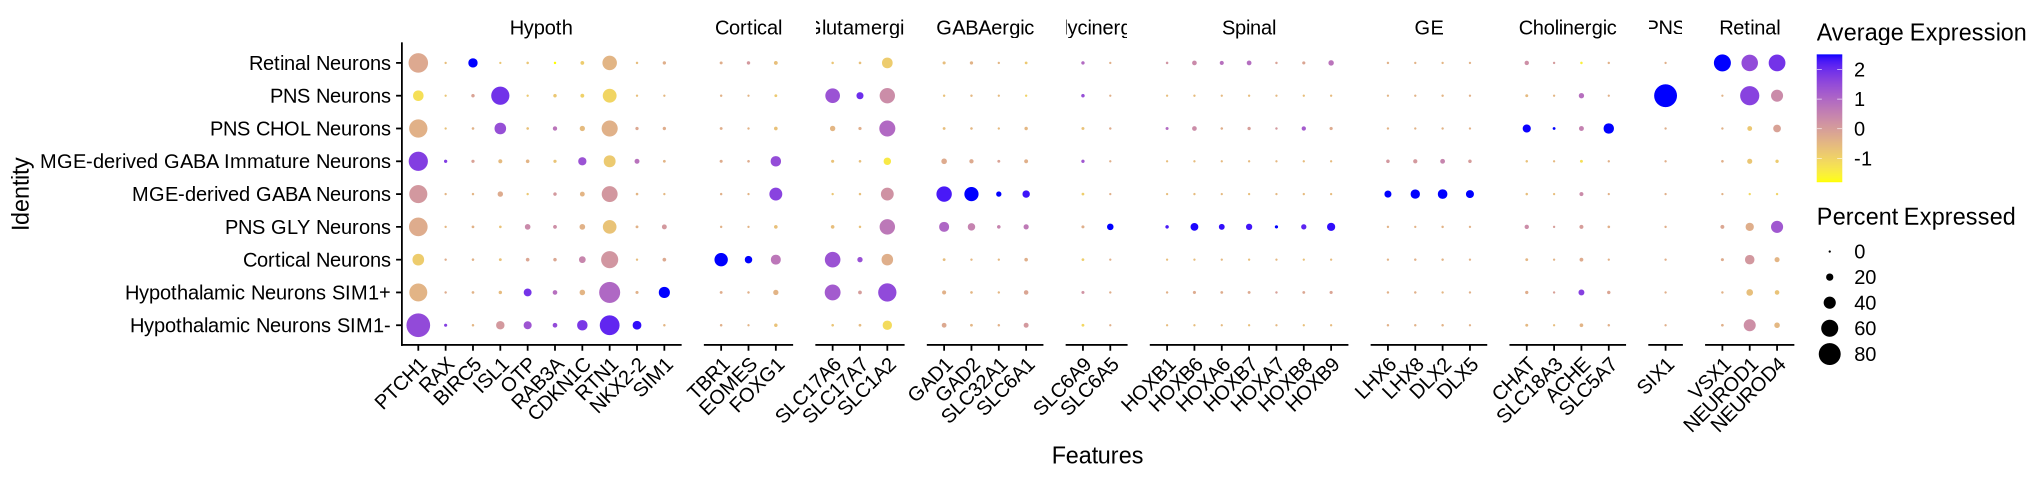

In [63]:
options(repr.plot.height=4, repr.plot.width=17)

marker_genes_neurons_dict <- list(
     Hypoth = c("PTCH1","RAX",'BIRC5', 'ISL1', 'OTP','RAB3A',
                            'CDKN1C',  'RTN1',
                               'NKX2-2', 'SIM1'),
    Cortical = c('TBR1',"EOMES", 'FOXG1'),

    Glutamergic = c('SLC17A6', 'SLC17A7', 'SLC1A2'),
    
    GABAergic = c('GAD1', 'GAD2', 'SLC32A1', 'SLC6A1'),
    Glycinergic = c('SLC6A9', 'SLC6A5'),
    Spinal =c('HOXB1', 'HOXB6', 'HOXA6', 'HOXB7', 'HOXA7', 'HOXB8', 'HOXB9'),

    GE=c("LHX6", "LHX8", "DLX2", "DLX5"),
     Cholinergic = c('CHAT', 'SLC18A3', 'ACHE', 'SLC5A7'),
    PNS = c("SIX1"),
    Retinal = c("VSX1", "NEUROD1","NEUROD4")
          )




neurons$neurons_name  <- factor(x = neurons$neurons_name, levels = c('Hypothalamic Neurons SIM1-','Hypothalamic Neurons SIM1+',  'Cortical Neurons',
                                                                     'PNS GLY Neurons',  'MGE-derived GABA Neurons','MGE-derived GABA Immature Neurons',
                                                                      'PNS CHOL Neurons','PNS Neurons','Retinal Neurons' ) )
Idents(neurons)<-"neurons_name"
DotPlot(neurons,  features =marker_genes_neurons_dict, 
        cols= c("yellow", "blue")
        )+ RotatedAxis()
ggsave(paste0(PATH_FILE, "neurons_markers.png"), width = 17, height = 4,dpi=300)